# 課題：NotMnist_largeで、できるだけ性能のいい学習器を作る

## 目的
MNISTのデータセットの取り扱いをNotMNISTに変更し、正答率の高い学習器を作ることを目的とする。
* notMNISTなどの外部データの正確な取り扱いと、配列への変換
    MNISTはTensorflowから、簡単にインポートが可能である。そこで、違うデータセットを使う場合はどのような操作をしなければならないかを、ソースコードから、知ることができる

* 正答率が高い学習器の作成
学習器はこれまで様々にならって来たが、今回のデータセットで、どれだけ正答率を上げることができるかが重要である。よって今回は、１層と、２層で試して見たいと思う。

## 方法
まず、以下のコード（'http://enakai00.hatenablog.com/entry/2016/08/02/102917')
を実行する。このコードは、ディレクトリの名称を取得し、配列に正解の値を格納、また、画像を28✖️28で取り込み、訓練用イメージと、テスト用イメージを作り出す。

In [7]:
import numpy as np
from sklearn.cross_validation import train_test_split
from PIL import Image
import os

class NotMNIST:
    def __init__(self):
        images, labels = [], []

        for i, letter in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']):
            directory = 'notMNIST_large/%s/' % letter
            files = os.listdir(directory)
            label = np.array([0]*10)
            label[i] = 1
            i = 0
            for file in files:
                try:
                    i+=1
                    im = Image.open(directory+file)
                    if i % 20000 == 0:
                        print("ok")
                except:
                    print ("Skip a corrupted file: " + file)
                    continue
                pixels = np.array(im.convert('L').getdata())
                images.append(pixels/255.0)
                labels.append(label)
          
        train_images, test_images, train_labels, test_labels = \
            train_test_split(images, labels, test_size=0.2, random_state=0)
        
        class train:
            def __init__(self):
                self.images = []
                self.labels = []
                self.batch_counter = 0
                
            def next_batch(self, num):
                if self.batch_counter + num >= len(self.labels):
                    batch_images = self.images[self.batch_counter:]
                    batch_labels = self.labels[self.batch_counter:]
                    left = num - len(batch_labels)
                    batch_images.extend(self.images[:left])
                    batch_labels.extend(self.labels[:left])
                    self.batch_counter = left
                else:
                    batch_images = self.images[self.batch_counter:self.batch_counter+num]
                    batch_labels = self.labels[self.batch_counter:self.batch_counter+num]                  
                    self.batch_counter += num
                    
                return (batch_images, batch_labels)
                    
        class test:
            def __init__(self):
                self.images = []
                self.labels = []
                
        self.train = train()
        self.test = test()
                
        self.train.images = train_images
        self.train.labels = train_labels
        self.test.images = test_images
        self.test.labels = test_labels

/Users/yamamotomasaomi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


次に、変数mnistに、NotMnist()の実行結果を格納する

In [ ]:
mnist=NotMNIST()
!store mnist

必要なライブラリのインポートと、ランダムシードの調整、グラフ表示のためのコンフィグを有効にする。

In [1]:
#  必要な素材の収集
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
import sys, os, pickle
import numpy.random as rd

from scipy.misc import imread

import matplotlib.pyplot as plt

# ランダムシードの作成
np.random.seed(20160703)
tf.set_random_seed(20160703)


# その他コンフィグ（いつもの）
%config IPCompleter.greedy=True
%matplotlib inline
%matplotlib notebook

#画像取り込みデータのオープン
# !ls session_MNIST_Image*

今回は、2層のフィルターを用いた画像認識の機械学習にした。

In [2]:
# フィルターに対応するvariableを用意して、入力データに、フィルターと
# プーリング層（画像の画質を落とすことによって結果の質をあげることができるための処理を行う層）を作る。

# フィルターの作成
num_filters = 16

# Placeholderの設定
x = tf.placeholder(tf.float32, [None, 784])

#プーリング層の設定？
x_image = tf.reshape(x, [-1, 28, 28, 1])

w_conv = tf.Variable(tf.truncated_normal([5, 5, 1,num_filters], 
                                         stddev = 0.1))
h_conv = tf.nn.conv2d(x_image, w_conv, 
                      strides=[1, 1, 1, 1], padding='SAME')

h_pool = tf.nn.max_pool(h_conv ,ksize = [1, 2, 2, 1], 
                        strides=[1, 2, 2, 1], padding='SAME')

In [3]:
# プーリング層からの出力を全結合層を経由してソフトマックス関数に入力する計算式を定義する
h_pool_flat = tf.reshape(h_pool, [-1, 14*14*num_filters])

# ノードの作成
num_units1 = 14*14*num_filters
num_units2 = 1024

# 隠れ層２の作成
w2 = tf.Variable(tf.truncated_normal([num_units1,num_units2]))
b2 = tf.Variable(tf.zeros([num_units2]))
# 高速化のためか、reluを使用
hidden2 = tf.nn.relu(tf.matmul(h_pool_flat, w2) + b2)

# 出力層の作成
w0 = tf.Variable(tf.zeros([num_units2,10]))
b0 = tf.Variable(tf.zeros([10]))
p = tf.nn.softmax(tf.matmul(hidden2,w0) + b0)

In [4]:
t = tf.placeholder(tf.float32, [None ,10])
loss = -tf.reduce_sum(t*tf.log(p))
train_step = tf.train.AdamOptimizer(0.005).minimize(loss)
correct_prediction = tf.equal(tf.argmax(p ,1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [5]:
# Variableの初期化
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
# 次の処理で、notmnistの値もどうやら保存されている模様なので、セッションオープンすればいけるかもしれないが、
# OneCellでは変数の数が合わないため、、別の方法を使う必要
# saver.save(sess, '/Users/yamamotomasaomi/Documents/GitHub/Python_Study/Not Orenist/convert/session_MNIST_Image') 
# saver.restore(sess,'/Users/yamamotomasaomi/Documents/GitHub/Python_Study/Not Orenist/convert/session_C-1000') 

In [6]:
i = 0
loss_vals, acc_vals = [], []
for _ in range (2000):
    i+=1
    batch_xs, batch_ts = mnist.train.next_batch(50) 
    sess.run(train_step,
             feed_dict={x:batch_xs, t: batch_ts})

#     loss_val, acc_val = sess.run([loss,accuracy],feed_dict={x:batch_xs,t:batch_ts})
#     loss_vals.append(loss_val)
#     acc_vals.append(acc_vals)
    
    if i % 100 == 0:
        for c in range(4):
            start = len(mnist.test.labels) // 4 * c
            end = len(mnist.test.labels) // 4 * (c+1)
            loss_val, acc_val = sess.run([loss,accuracy],feed_dict={x:mnist.test.images[start:end],t:mnist.test.labels[start:end]})
            loss_vals.append(loss_vals)
            acc_vals.append(acc_vals)
        loss_val = np.sum(loss_vals)
        acc_val = np.mean(acc_vals)
        print('Step: %d, Loss:%f, Accuracy: %f' 
                % (i, loss_val, acc_val))
    if i % 1000 == 0:
        saver.save(sess, '/Users/yamamotomasaomi/Documents/GitHub/Python_Study/Not Orenist/convert/session_C', global_step=i)

NameError: name 'mnist' is not defined

## 結果
### AdamOptimizerを使用し、0.0005の値に設定した場合
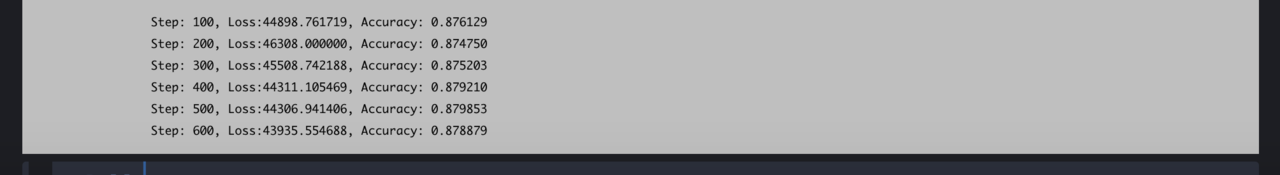
正答率は、0.88963という結果となった。まだ、改善が見込めそうであるため、学習回数を同じにして、学習率を100倍にしてみる。

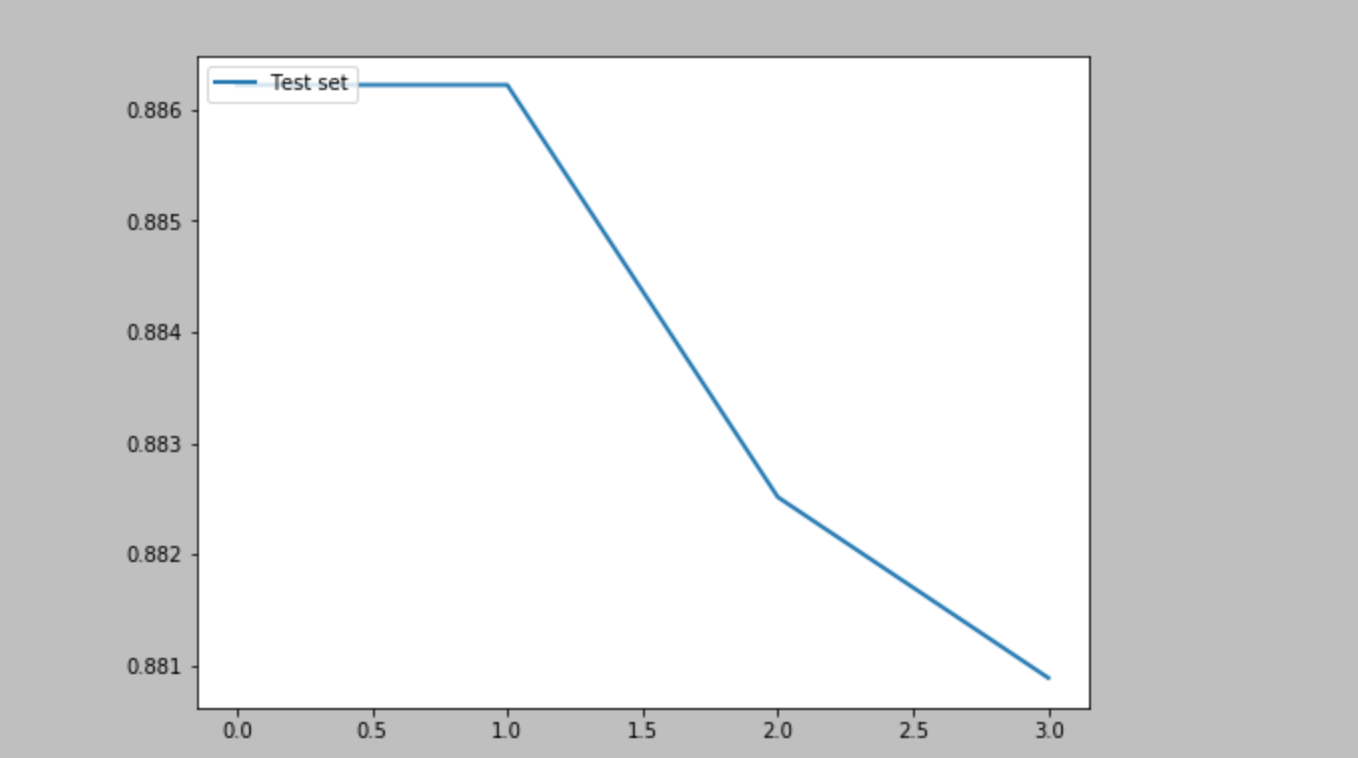

グラフでは減少しているように見えるが、実情は上昇しているため、グラフが違うように思える。

In [ ]:
fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1,1,1)
subplot.plot(range (len(acc_vals)),acc_vals,linewidth=2,label='Test set')
subplot.legend(loc='upper left')